----------
**Heart Disease Analysis and Prediction**
=====================================

***LGB : CV - Auc = .948 Recall = .915 Precision = .867***

***Vincent Lugat***

*July 2019*

----------

![](https://image.noelshack.com/fichiers/2019/27/6/1562430213-logo-heart-care.jpg)

![](http://)

- <a href='#1'>1. Libraries and Data</a>  
    - <a href='#1.1'>1.1. Loading libraries</a> 
    - <a href='#1.2'>1.2. Reading data</a> 
- <a href='#2'>2. Exploratory Data Analysis (EDA)</a> 
    - <a href='#2.1'>2.1. Head, describe and shape</a> 
    - <a href='#2.2'>2.2. Target count</a> 
    - <a href='#2.3'>2.3. Correlation Matrix</a> 
    - <a href='#2.4'>2.4. Univariate analysis</a> 
        - <a href='#2.4.1'>2.4.1. Numerical data</a> 
        - <a href='#2.4.2'>2.4.2. Categorical data</a> 
    - <a href='#2.5'>2.5. Bivariate analysis (vs target)</a> 
        - <a href='#2.5.1'>2.5.1. Numerical data</a> 
        - <a href='#2.5.2'>2.5.2. Categorical data</a> 
    - <a href='#2.6'>2.6. Multivariate analysis</a> 
        - <a href='#2.6.1'>2.6.1. Numerical data</a> 
        - <a href='#2.6.2'>2.6.2. Categorical data</a> 
        - <a href='#2.6.3'>2.6.3. Numerical & categorical data</a> 
- <a href='#3'>3. Feature engineering and preprossesing</a>
    - <a href='#3.1'>3.1. Feature engineering</a> 
    - <a href='#3.2'>3.2. Preprocessing</a> 
- <a href='#4'>4. Light GBM</a>
    - <a href='#4.1'>4.1. Confusion matrix function </a> 
    - <a href='#4.2'>4.2. Light GBM - hyperparameters </a> 
    - <a href='#4.3'>4.3. Light GBM - 5 folds </a>
    - <a href='#4.4'>4.4. Light GBM - Features importance</a>
- <a href='#5'>5. SHAP plot</a>
- <a href='#6'>6. Threshold (FP | FN)</a> 

1. age : age in years
2. sex : (1 = male; 0 = female)
3. cp : chest pain type (4 values) 
4. trestbps : resting blood pressure (in mm Hg on admission to the hospital)
5. chol : serum cholestoral in mg/dl 
6. fbs : fasting blood sugar > 120 mg/dl : (1 = true; 0 = false)
7. restecg : resting electrocardiographic results (values 0,1,2)
8. thalach : maximum heart rate achieved 
9. exang : exercise induced angina 
10. oldpeak : ST depression induced by exercise relative to rest 
11. the slope of the peak exercise ST segment 
12. ca : number of major vessels (0-3) colored by flourosopy 
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

# <a id='1'>1. Librairies and data</a> 

## <a id='1.1'>1.1. Loading libraries</a> 

In [1]:
# Python libraries
# Classic,data manipulation and linear algebra
from scipy import interp
import pandas as pd
import numpy as np
import itertools

# Plots
import shap
shap.initjs()
%matplotlib inline
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Data processing, metrics and modeling
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

# Filter werning
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)

/opt/conda/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


## <a id='1.2'>1.2. Reading data</a> 

In [2]:
#Dataset
data = pd.read_csv('../input/heart.csv')

# <a id='2'>2. Exploratory Data Analysis (EDA)</a>  

## <a id='2.1'>2.1. Head, describe and shape</a> 

In [3]:
display(data.head(5), data.describe(), data.shape)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


(303, 14)

## <a id='2.2'>2.2. Target count</a> 

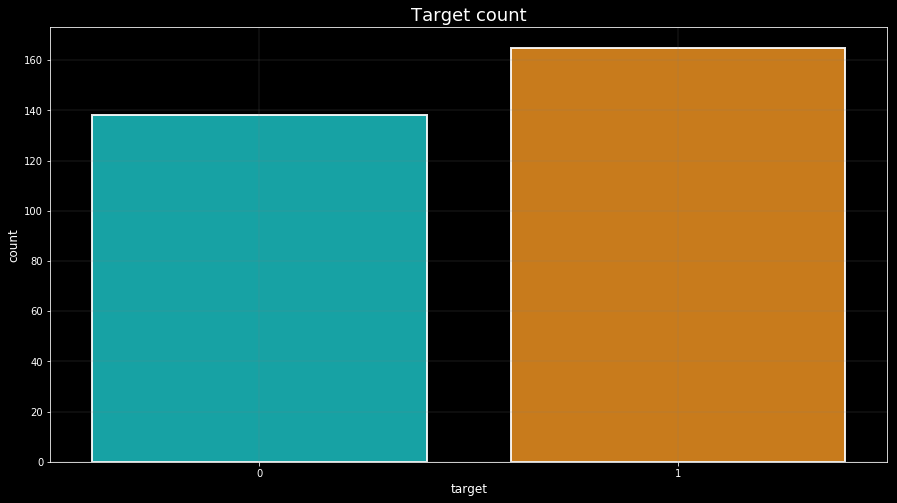

Percentage Haven't Heart Disease: 45.54%
Percentage Have Heart Disease: 54.46%


In [4]:
colors = ['darkturquoise', 'darkorange']
plt.style.use('dark_background')
plt.rcParams['figure.figsize']=(15,8)

ax = sns.countplot(x='target', data=data, palette=colors, alpha=0.9, edgecolor=('white'), linewidth=2)
ax.set_ylabel('count', fontsize=12)
ax.set_xlabel('target', fontsize=12)
ax.grid(b=True, which='major', color='grey', linewidth=0.2)
plt.title('Target count', fontsize=18)
plt.show()

target_0 = len(data[data.target == 0])
target_1 = len(data[data.target == 1])
print("Percentage Haven't Heart Disease: {:.2f}%".format((target_0 / (len(data.target))*100)))
print("Percentage Have Heart Disease: {:.2f}%".format((target_1 / (len(data.target))*100)))

## <a id='2.3'>2.3. Correlation matrix</a> 

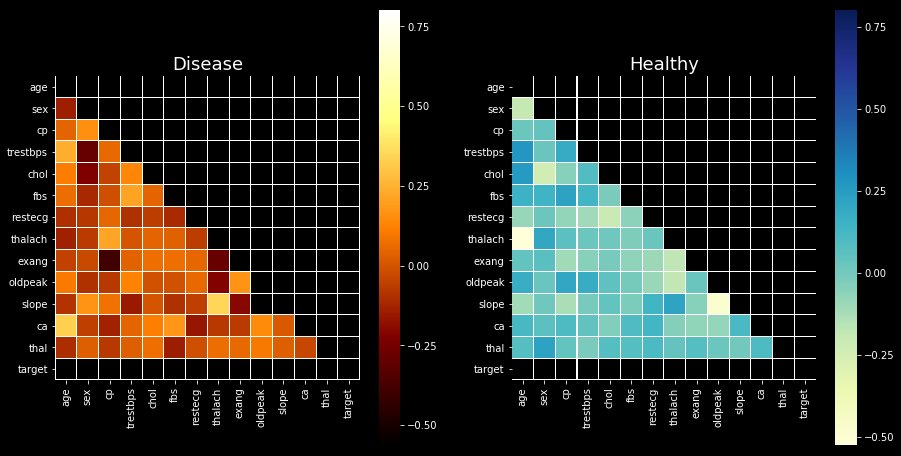

In [5]:
# Correlation matrix 
f, (ax1, ax2) = plt.subplots(1,2,figsize =(15, 8))
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
heatmapkws = dict(linewidths=0.1) 
sns.heatmap((data[data['target'] ==1]).corr(), vmax = .8, square=True, ax = ax2, cmap = 'YlGnBu', mask=mask, **heatmapkws);
ax1.set_title('Disease', fontsize=18)
sns.heatmap((data[data['target'] ==0]).corr(), vmax = .8, square=True, ax = ax1, cmap = 'afmhot', mask=mask,**heatmapkws);
ax2.set_title('Healthy', fontsize=18)
plt.show()

## <a id='2.4'>2.4. Univariate analysis</a> 

### <a id='2.4.1.'>2.4.1. Numerical data</a> 

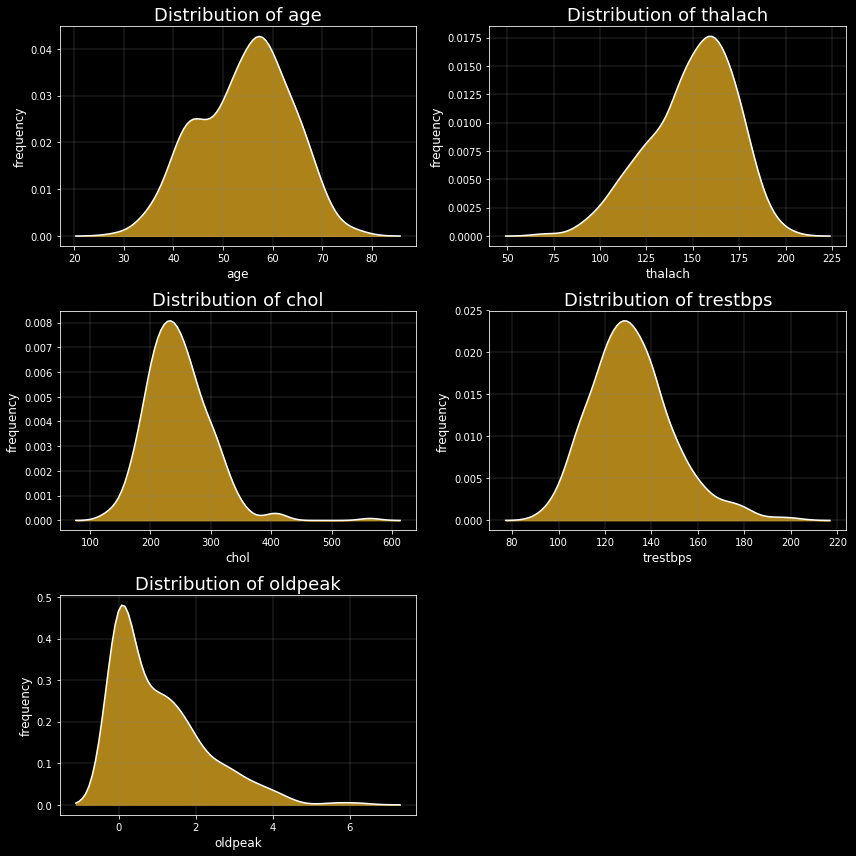

In [6]:
f,ax=plt.subplots(3,2,figsize=(12,12))
f.delaxes(ax[2,1])

for i,feature in enumerate(['age','thalach','chol','trestbps','oldpeak']):
    sns.distplot(data[feature], ax=ax[i//2,i%2], kde_kws={"color":"white"}, hist=False )

    # Get the two lines from the ax[i//2,i%2]es to generate shading
    l1 = ax[i//2,i%2].lines[0]

    # Get the xy data from the lines so that we can shade
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    ax[i//2,i%2].fill_between(x1,y1, color="goldenrod", alpha=0.8)

    #grid
    ax[i//2,i%2].grid(b=True, which='major', color='grey', linewidth=0.3)
    
    ax[i//2,i%2].set_title('Distribution of {}'.format(feature), fontsize=18)
    ax[i//2,i%2].set_ylabel('count', fontsize=12)
    ax[i//2,i%2].set_xlabel('Modality', fontsize=12)

    #sns.despine(ax[i//2,i%2]=ax[i//2,i%2], left=True)
    ax[i//2,i%2].set_ylabel("frequency", fontsize=12)
    ax[i//2,i%2].set_xlabel(str(feature), fontsize=12)
    
plt.tight_layout()
plt.show()

### <a id='2.4.2.'>2.4.2. Categorical data</a> 

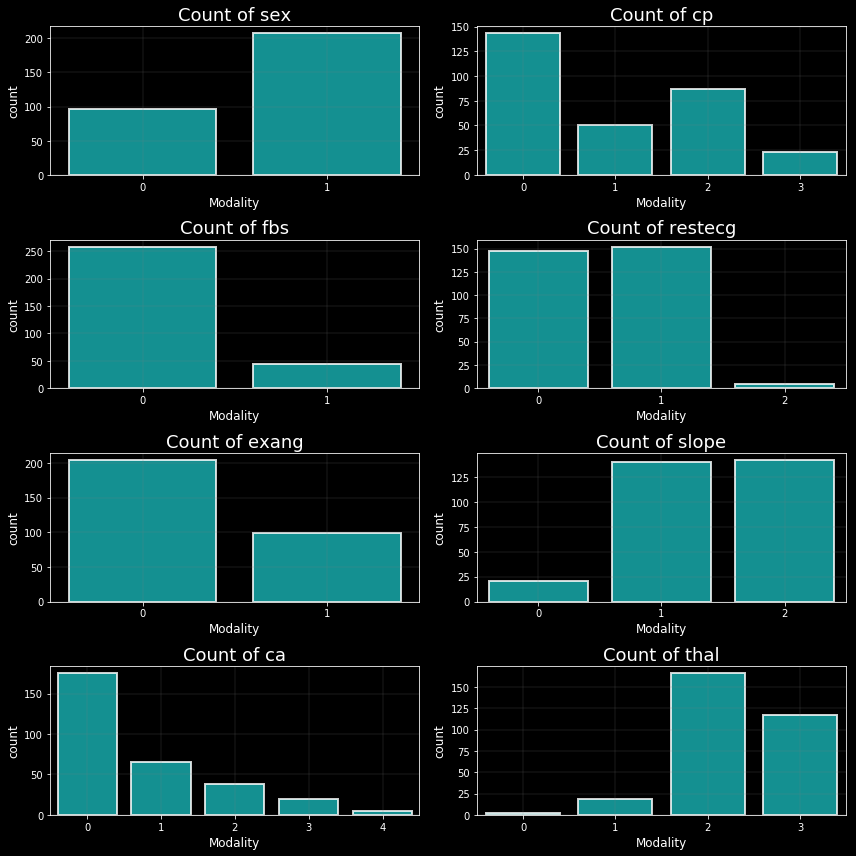

In [7]:
f,ax=plt.subplots(4,2,figsize=(12,12))

for i,feature in enumerate(['sex','cp','fbs','restecg','exang','slope','ca','thal']):
    colors = ['darkturquoise']
    sns.countplot(x=feature,data=data,ax=ax[i//2,i%2], palette = colors, alpha=0.8, edgecolor=('white'), linewidth=2)
    ax[i//2,i%2].grid(b=True, which='major', color='grey', linewidth=0.2)
    ax[i//2,i%2].set_title('Count of {}'.format(feature), fontsize=18)
    ax[i//2,i%2].set_ylabel('count', fontsize=12)
    ax[i//2,i%2].set_xlabel('Modality', fontsize=12)

plt.tight_layout()
plt.show()

## <a id='2.5'>2.5. Bivariate analysis (vs target)</a> 

### <a id='2.5.1.'>2.5.1. Numerical data</a> 

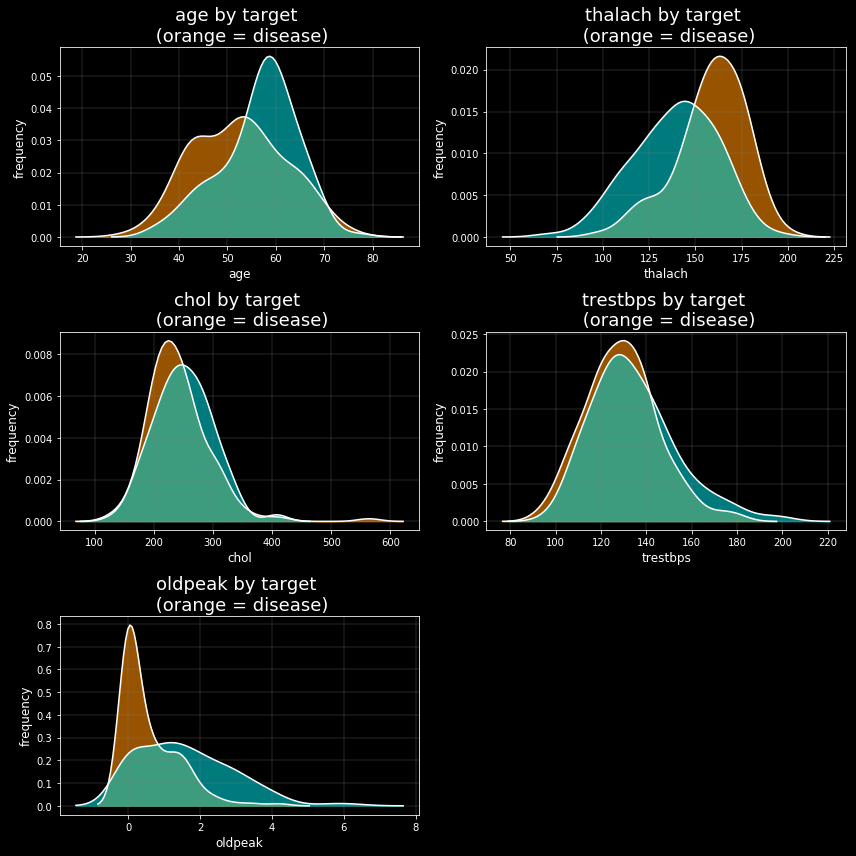

In [8]:
f,ax=plt.subplots(3,2,figsize=(12,12))
f.delaxes(ax[2,1])

for i,feature in enumerate(['age','thalach','chol','trestbps','oldpeak','age']):
    sns.distplot(data[data['target']==0][(feature)], ax=ax[i//2,i%2], kde_kws={"color":"white"}, hist=False )
    sns.distplot(data[data['target']==1][(feature)], ax=ax[i//2,i%2], kde_kws={"color":"white"}, hist=False )

    # Get the two lines from the ax[i//2,i%2]es to generate shading
    l1 = ax[i//2,i%2].lines[0]
    l2 = ax[i//2,i%2].lines[1]

    # Get the xy data from the lines so that we can shade
    x1 = l1.get_xydata()[:,0]
    y1 = l1.get_xydata()[:,1]
    x2 = l2.get_xydata()[:,0]
    y2 = l2.get_xydata()[:,1]
    ax[i//2,i%2].fill_between(x2,y2, color="darkorange", alpha=0.6)
    ax[i//2,i%2].fill_between(x1,y1, color="darkturquoise", alpha=0.6)

    #grid
    ax[i//2,i%2].grid(b=True, which='major', color='grey', linewidth=0.3)
    
    ax[i//2,i%2].set_title('{} by target \n (orange = disease)'.format(feature), fontsize=18)
    ax[i//2,i%2].set_ylabel('count', fontsize=12)
    ax[i//2,i%2].set_xlabel('Modality', fontsize=12)

    #sns.despine(ax[i//2,i%2]=ax[i//2,i%2], left=True)
    ax[i//2,i%2].set_ylabel("frequency", fontsize=12)
    ax[i//2,i%2].set_xlabel(str(feature), fontsize=12)

plt.tight_layout()
plt.show()

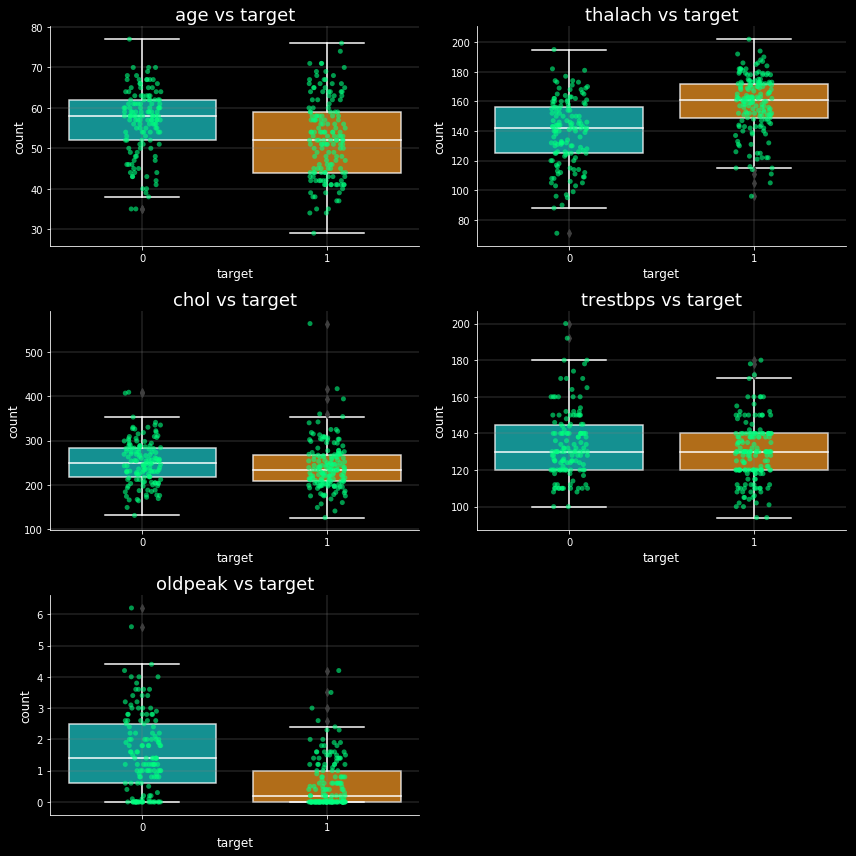

In [9]:
f,ax=plt.subplots(3,2,figsize=(12,12))
f.delaxes(ax[2,1])
colors=['darkturquoise','darkorange']
for i,feature in enumerate(['age','thalach','chol','trestbps','oldpeak']):
    sns.boxplot(x='target', y=feature, data=data , ax=ax[i//2,i%2], palette=colors, boxprops=dict(alpha=0.8))
    sns.stripplot(y=feature, x='target', 
                          data=data,
                          ax=ax[i//2,i%2],
                          jitter=True, marker='o',
                          alpha=0.6, 
                          color="springgreen")

    ax[i//2,i%2].grid(b=True, which='major', color='grey', linewidth=0.2)
    ax[i//2,i%2].set_title('Count of {}'.format(feature), fontsize=18)
    ax[i//2,i%2].set_ylabel('count', fontsize=12)
    ax[i//2,i%2].set_xlabel('Modality', fontsize=12)
    
    sns.despine()
    ax[i//2,i%2].grid(b=True, which='major', color='grey', linewidth=0.4)

    ax[i//2,i%2].set_title(str(feature)+' '+'vs'+' '+'target', fontsize=18)
    ax[i//2,i%2].set_ylabel("count", fontsize=12)
    ax[i//2,i%2].set_xlabel(('target'), fontsize=12)

    plt.setp(ax[i//2,i%2].artists, edgecolor = 'white')
    plt.setp(ax[i//2,i%2].lines, color='white')

plt.tight_layout()
plt.show()

### <a id='2.5.2.'>2.5.2. Categorical data</a> 

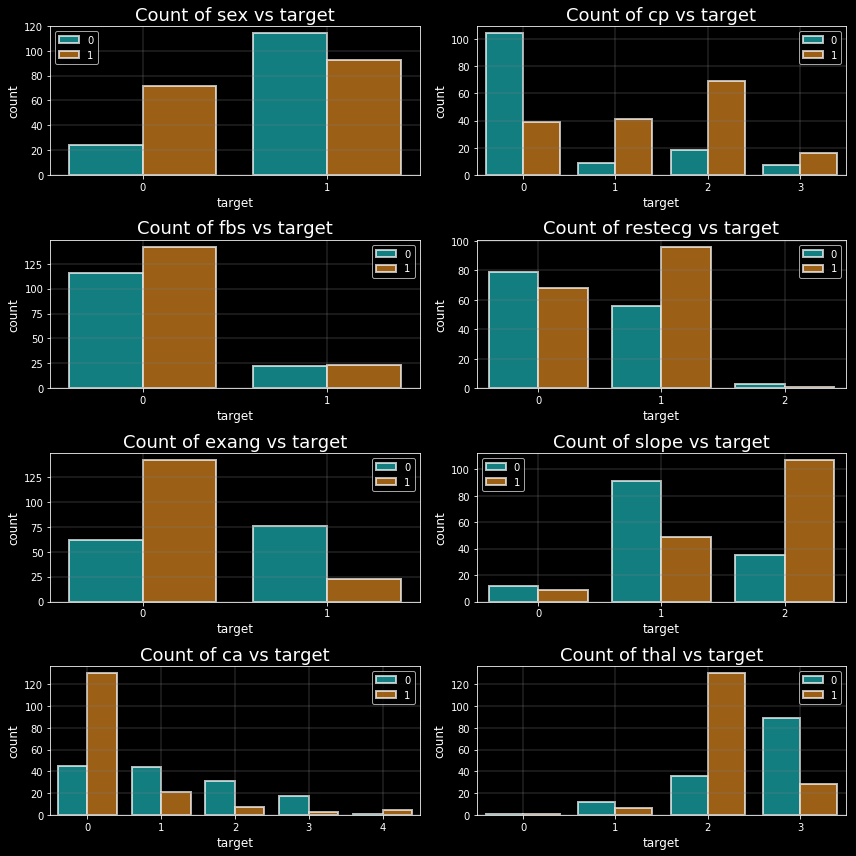

In [10]:
f,ax=plt.subplots(4,2,figsize=(12,12))

for i,feature in enumerate(['sex','cp','fbs','restecg','exang','slope','ca','thal']):
    colors = ['darkturquoise', 'darkorange']
    sns.countplot(x=feature,data=data,hue='target',ax=ax[i//2,i%2], palette = colors, alpha=0.7, edgecolor=('white'), linewidth=2)
    ax[i//2,i%2].grid(b=True, which='major', color='grey', linewidth=0.4)
    ax[i//2,i%2].set_title('Count of {} vs target'.format(feature), fontsize=18)
    ax[i//2,i%2].legend(loc='best')
    ax[i//2,i%2].set_ylabel('count', fontsize=12)
    ax[i//2,i%2].set_xlabel('target', fontsize=12)

plt.tight_layout()
plt.show()

## <a id='2.6'>2.6. Multivariate analysis</a> 

### <a id='2.6.1.'>2.6.1. Numerical data</a> 

In [11]:
def scatterplot(var1,var2,var3,var4):
    f,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
    #f.delaxes(ax[2,1])
    
    colors = ['darkturquoise','darkorange']
    ax1 = sns.scatterplot(x = data[var1], y = data[var2], hue = "target",
                        data = data,  ax=ax1, palette=colors, alpha=0.8, edgecolor="white",linewidth=0.1)
    ax1.grid(b=True, which='major', color='lightgrey', linewidth=0.2)
    ax1.set_title(str(var1)+' '+'vs'+' '+str(var2)+' '+'vs target', fontsize=18)
    ax1.set_xlabel(str(var1), fontsize=12)
    ax1.set_ylabel(str(var2), fontsize=12)

    ax2 = sns.scatterplot(x = data[var3], y = data[var4], hue = "target",
                        data = data,  ax=ax2, palette=colors, alpha=0.8, edgecolor="white",linewidth=0.1)
    ax2.grid(b=True, which='major', color='lightgrey', linewidth=0.2)
    ax2.set_title(str(var3)+' '+'vs'+' '+str(var4)+' '+'vs target', fontsize=18)
    ax2.set_xlabel(str(var1), fontsize=12)
    ax2.set_ylabel(str(var2), fontsize=12)

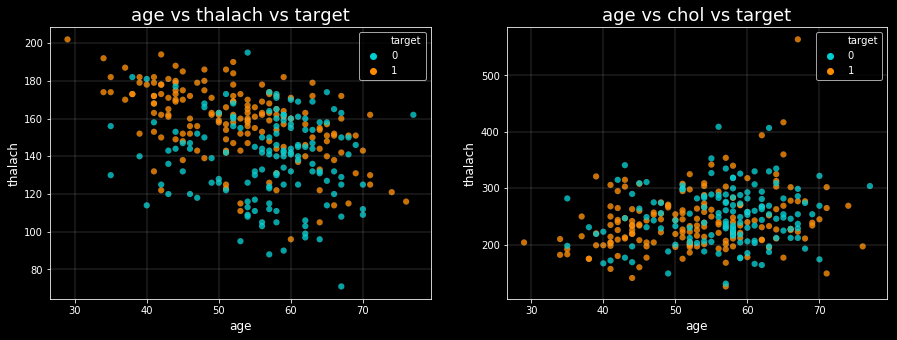

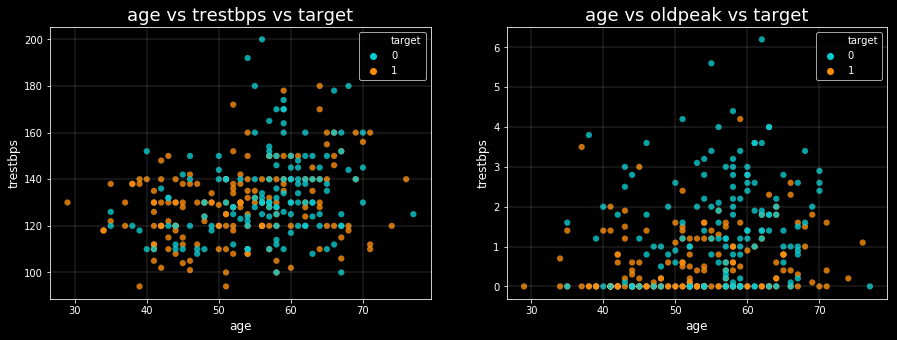

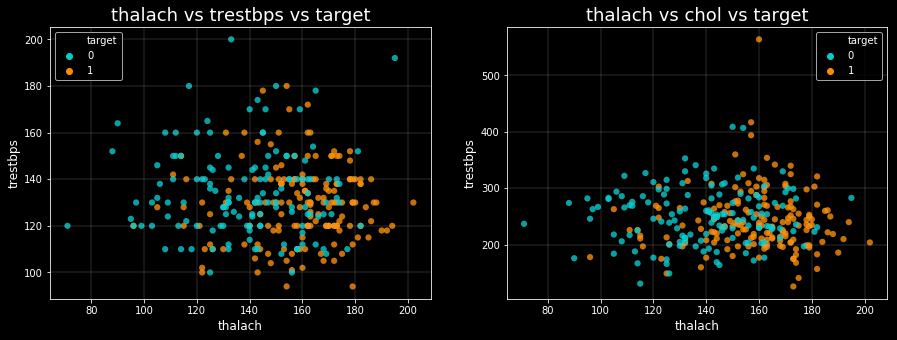

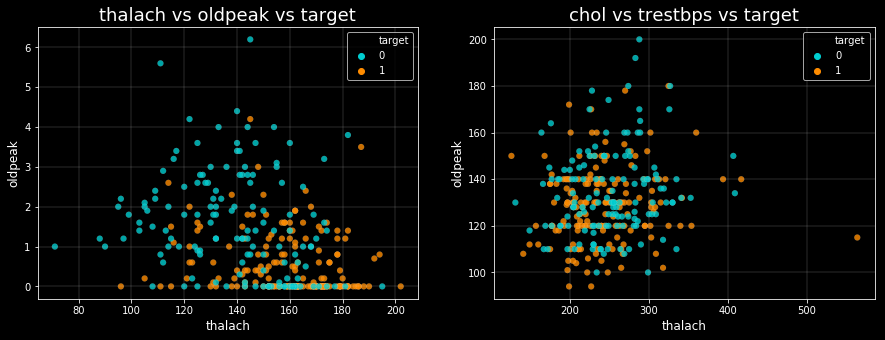

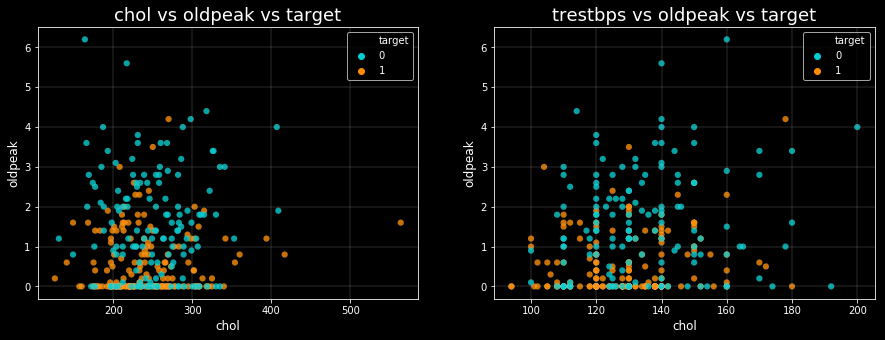

In [12]:
scatterplot('age','thalach','age', 'chol')
scatterplot('age','trestbps','age', 'oldpeak')
scatterplot('thalach','trestbps','thalach', 'chol')
scatterplot('thalach','oldpeak','chol', 'trestbps')
scatterplot('chol','oldpeak','trestbps', 'oldpeak')

### <a id='2.6.2.'>2.6.2. Categorical data</a> 

In [13]:
def multivariate_count(var):
    for x in [
        #'sex',
        'cp',
        'fbs',
        #'restecg',
        #'exang',
        #'slope',
        #'ca',
        'thal']:
        ax = sns.catplot(x=x, hue="target", col=var, 
               data=data, kind="count", palette = ['darkturquoise', 'darkorange'], alpha=0.7, edgecolor=('white'), linewidth=2)
        ax.fig.suptitle(str(var)+' vs '+str(x)+' vs target', fontsize=18) # can also get the figure from plt.gcf()
    
        #plt.grid(b=True, which='major', color='grey', linewidth=0.4)
        plt.subplots_adjust(top=0.8)
        plt.show()  

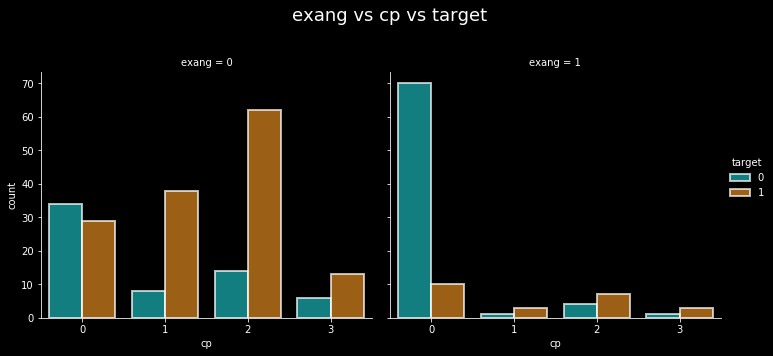

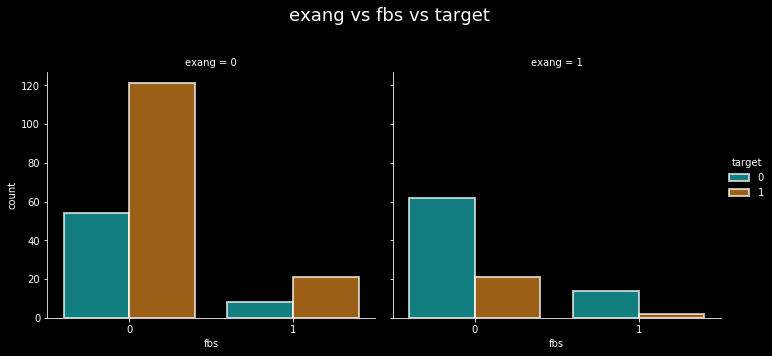

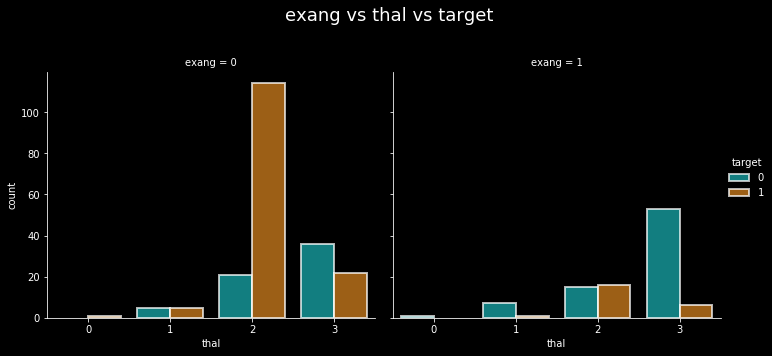

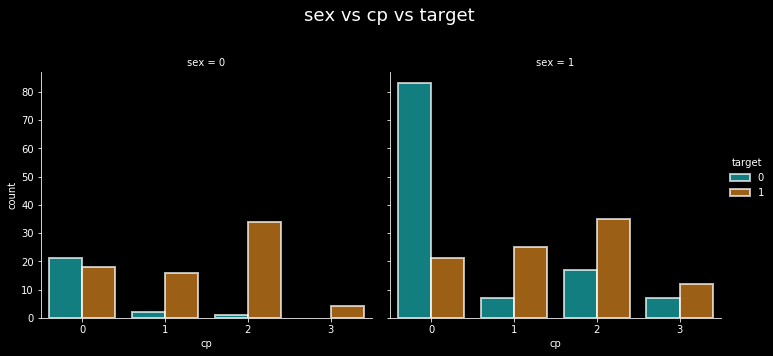

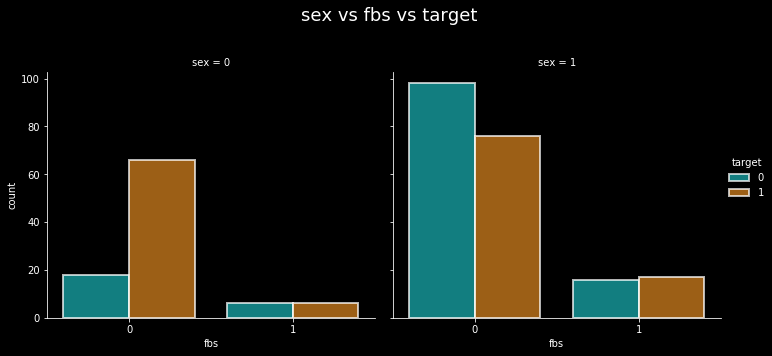

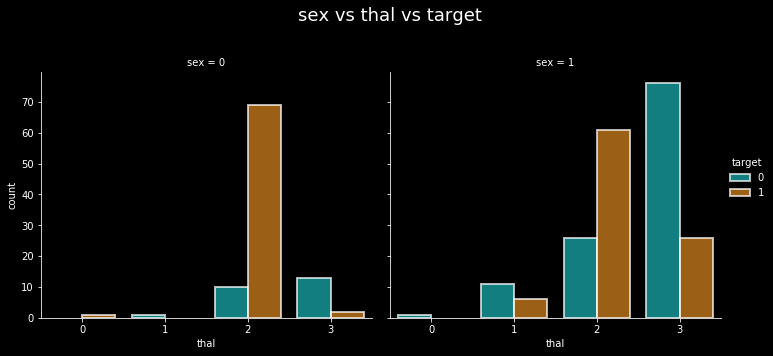

In [14]:
multivariate_count('exang')
#multivariate_count('fbs')
#multivariate_count('cp')
#multivariate_count('ca')
#multivariate_count('restecg')
#multivariate_count('slope')
#multivariate_count('thal')
multivariate_count('sex')

### <a id='2.6.3.'>2.6.3. Numerical & categorical data</a> 

In [15]:
def multivariate_swarn(col,x,y):
    g = sns.FacetGrid(data, col=col, hue='target', palette = ['darkturquoise', 'darkorange'], height=5)
    ax = g.map(sns.swarmplot, x, y, alpha=0.7, edgecolor=('white'), linewidth=0.1)
    ax.fig.suptitle(str(x)+' vs '+str(y)+' by '+str(col)+' vs target', fontsize=18) 
    plt.subplots_adjust(top=0.8)
    plt.show()

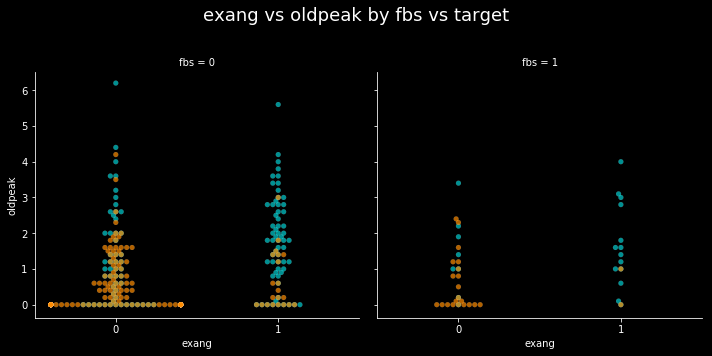

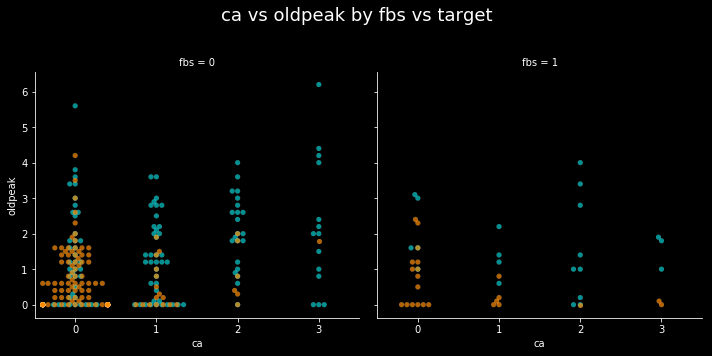

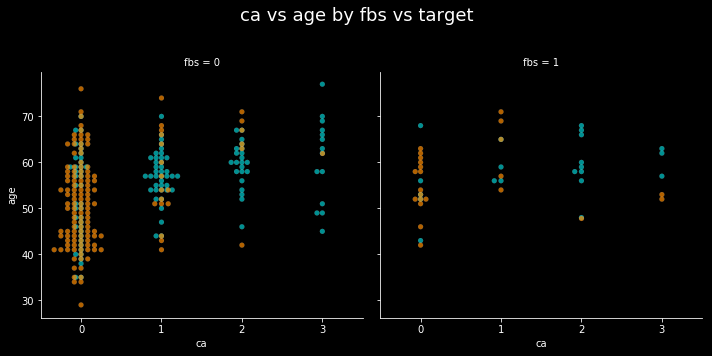

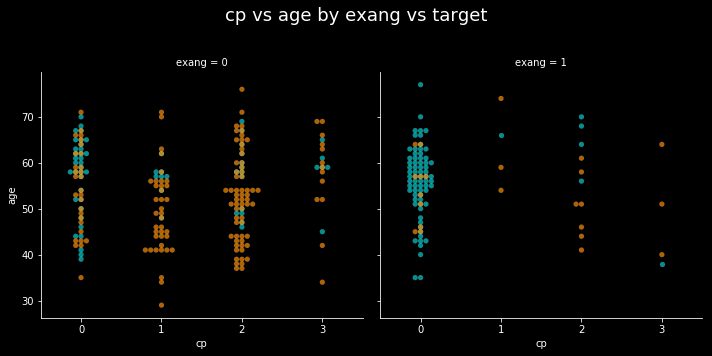

In [16]:
multivariate_swarn('fbs','exang','oldpeak')
#multivariate_swarn('exang','thal','thalach')
#multivariate_swarn('sex','thal','chol')
#multivariate_swarn('slope','ca','age')

multivariate_swarn('fbs','ca','oldpeak')
#multivariate_swarn('exang','cp','thalach')
#multivariate_swarn('sex','restecg','chol')
#multivariate_swarn('slope','thal','age')

multivariate_swarn('fbs','ca','age')
#multivariate_swarn('exang','cp','oldpeak')
#multivariate_swarn('sex','restecg','thalach')
#multivariate_swarn('slope','thal','chol')

multivariate_swarn('exang','cp','age')
#multivariate_swarn('restecg','ca','oldpeak')
#multivariate_swarn('ca','sex','thalach')
#multivariate_swarn('cp','slope','chol')

# <a id='3'>3. Feature engineering and Preprocessing</a>  

## <a id='3.1'>3.1. Feature engineering</a> 

In [17]:
data['oldpeak_x_age'] = data['oldpeak'] * data['age']
data['oldpeak_div_age'] = data['oldpeak'] / data['age']
data['ca_div_age'] = data['ca'] / data['age']
data['oldpeak_square'] = data['oldpeak'] * data['oldpeak']

data = data.fillna(0)

features = list(data)
features.remove('target')

idx = features 
for df in [data]:
    df['sum'] = df[idx].sum(axis=1)  
    df['count'] = df[idx].count(axis=1)  
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurtosis(axis=1)
    df['med'] = df[idx].median(axis=1)

## <a id='3.1'>3.1. Preprocessing</a> 

In [18]:
def preprocessing(dataset, y):
    target_col = [y]
    cat_cols   = dataset.nunique()[dataset.nunique() < 5].keys().tolist()
    cat_cols   = [x for x in cat_cols ]
    #numerical columns
    num_cols   = [x for x in dataset.columns if x not in cat_cols + target_col]
    #Binary columns with 2 values
    bin_cols   = dataset.nunique()[dataset.nunique() == 2].keys().tolist()
    #Columns more than 2 values
    multi_cols = [i for i in cat_cols if i not in bin_cols]

    #Label encoding Binary columns
    le = LabelEncoder()
    for i in bin_cols :
        dataset[i] = le.fit_transform(dataset[i])

    #Duplicating columns for multi value columns
    dataset = pd.get_dummies(data = dataset,columns = multi_cols )

    #Scaling Numerical columns
    std = StandardScaler()
    scaled = std.fit_transform(dataset[num_cols])
    scaled = pd.DataFrame(scaled,columns=num_cols)

    #dropping original values merging scaled values for numerical columns
    df_dataset_og = dataset.copy()
    dataset = dataset.drop(columns = num_cols,axis = 1)
    dataset = dataset.merge(scaled,left_index=True,right_index=True,how = "left")
    return dataset

In [19]:
data = preprocessing(data,'target')

In [20]:
train_df = data
features = list(train_df)
features.remove('target')
target = train_df['target']

# <a id='4'>4. Light GBM</a>  

## <a id='4.1'>4.1. Confusion Matrix function</a> 

In [21]:
# Confusion matrix 
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix"',
                          cmap = plt.cm.Blues) :
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

## <a id='4.2'>4.2. Light GBM hyperparameters</a> 

In [22]:
model = lgb.LGBMClassifier(**{
                'learning_rate': 0.06,
                'feature_fraction': 0.7,
                'bagging_freq': 6,
                'scale_pos_weight': 1,         
                'bagging_fraction': 0.3,
                'max_depth':-1,
                'objective': 'binary',
                'n_jobs': -1,
                'n_estimators':5000,
                'metric':'auc',
                'save_binary': True,
                'feature_fraction_seed': 42,
                'bagging_seed': 42,
                'boosting_type': 'gbdt',
                'verbose': 1,
                'is_unbalance': False,
                'boost_from_average': True
})

## <a id='4.3'>4.3. Light GBM : 5 folds </a> 

Fold: 0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.920996
[200]	valid_0's auc: 0.942641
[300]	valid_0's auc: 0.931818
Early stopping, best iteration is:
[210]	valid_0's auc: 0.961039
Fold: 1
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.931818
Early stopping, best iteration is:
[30]	valid_0's auc: 0.965368
Fold: 2
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.91342
[200]	valid_0's auc: 0.927489
[300]	valid_0's auc: 0.893939
Early stopping, best iteration is:
[223]	valid_0's auc: 0.941558
Fold: 3
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.912458
Early stopping, best iteration is:
[61]	valid_0's auc: 0.937149
Fold: 4
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.864198
Early stopping, best iteration is:
[9]	valid_0's auc: 0.909091

CV roc score        : 0.9428, std: 0.0201. 
CV accurac

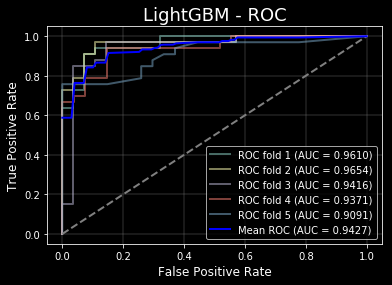

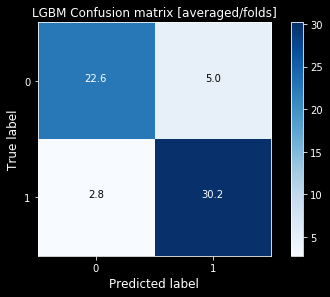

In [23]:
plt.rcParams['figure.figsize']=(6,4)

cms= []
tprs = []
aucs = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []

oof = np.zeros(len(train_df))
mean_fpr = np.linspace(0,1,100)
feature_importance_df = pd.DataFrame()
i = 1

folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=42)
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print('Fold:', fold_ )
    model = model.fit(train_df.iloc[trn_idx][features], target.iloc[trn_idx],
                      eval_set = (train_df.iloc[val_idx][features], target.iloc[val_idx]),
                      verbose = 100,
                      eval_metric = 'auc',
                      early_stopping_rounds = 100)
    
    oof[val_idx] =  model.predict_proba(train_df.iloc[val_idx][features])[:,1]
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = model.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # Roc curve by fold
    fpr, tpr, t = roc_curve(train_df.target[val_idx], oof[val_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    i= i+1
    
    # Shap values
    explainer = shap.TreeExplainer(model)
    shap_values = shap.TreeExplainer(model).shap_values(train_df.iloc[val_idx][features])
    
    # Scores 
    roc_aucs.append(roc_auc_score(train_df.target[val_idx], oof[val_idx]))
    accuracies.append(accuracy_score(train_df.target[val_idx], oof[val_idx].round()))
    recalls.append(recall_score(train_df.target[val_idx], oof[val_idx].round()))
    precisions.append(precision_score(train_df.target[val_idx], oof[val_idx].round()))
    f1_scores.append(f1_score(train_df.target[val_idx], oof[val_idx].round()))
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train_df.target[val_idx], oof[val_idx].round()))
    
# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

# Roc curve
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % ((mean_auc)),lw=2, alpha=1)
plt.grid(b=True, which='major', color='grey', linewidth=0.4)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('LightGBM - ROC', fontsize=18)
plt.legend(loc="lower right")
plt.show()

# Confusion matrix 
plt.rcParams["axes.grid"] = False
cm = np.average(cms, axis=0)
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title='LGBM Confusion matrix [averaged/folds]')
plt.show()

## <a id='4.4'>4.4. Light GBM : Features importance </a> 

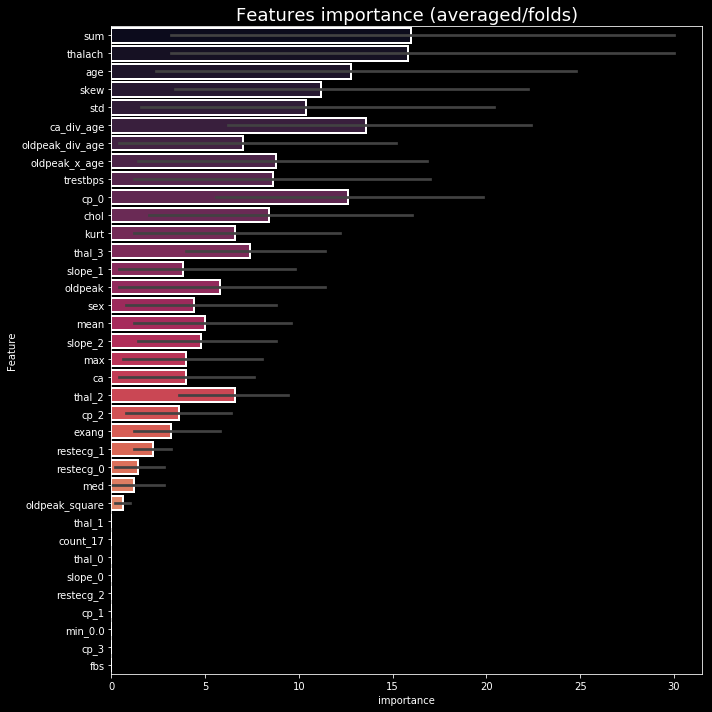

In [24]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:37].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10,10))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False),
            edgecolor=('white'), linewidth=2, palette="rocket")
plt.title('Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()

# <a id='5'>5. SHAP plots</a> 

In [25]:
display(
shap.force_plot(explainer.expected_value, shap_values[0,:], train_df.iloc[val_idx][features].iloc[0,:],figsize=(10, 5)),
shap.force_plot(explainer.expected_value, shap_values[1,:], train_df.iloc[val_idx][features].iloc[1,:],figsize=(10, 5)),
shap.force_plot(explainer.expected_value, shap_values[2,:], train_df.iloc[val_idx][features].iloc[2,:],figsize=(10, 5)),
shap.force_plot(explainer.expected_value, shap_values[3,:], train_df.iloc[val_idx][features].iloc[3,:],figsize=(10, 5)),
shap.force_plot(explainer.expected_value, shap_values[4,:], train_df.iloc[val_idx][features].iloc[4,:],figsize=(10, 5)),
shap.force_plot(explainer.expected_value, shap_values[5,:], train_df.iloc[val_idx][features].iloc[5,:],figsize=(10, 5)))

In [26]:
shap.force_plot(explainer.expected_value, shap_values, train_df.iloc[val_idx][features],figsize=(10, 5), plot_cmap='RdBu')

# <a id='6'>6. Threshold (FP | FN)</a> 

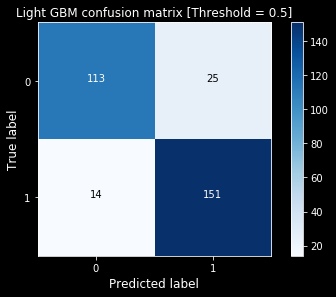

In [27]:
oof[val_idx] = model.predict_proba(train_df.iloc[val_idx][features])[:,1]
cm = confusion_matrix(target, oof.round())
class_names = [0,1]
plot_confusion_matrix(cm, 
                      classes=class_names, 
                      title="Light GBM confusion matrix [Threshold = 0.5]") 

Recall w/ threshold = 0.1 : 0.9212121212121213
Recall w/ threshold = 0.2 : 0.9212121212121213
Recall w/ threshold = 0.3 : 0.9212121212121213
Recall w/ threshold = 0.4 : 0.9151515151515152
Recall w/ threshold = 0.5 : 0.9151515151515152
Recall w/ threshold = 0.6 : 0.8727272727272727
Recall w/ threshold = 0.7 : 0.7575757575757576
Recall w/ threshold = 0.8 : 0.7212121212121212
Recall w/ threshold = 0.9 : 0.7212121212121212


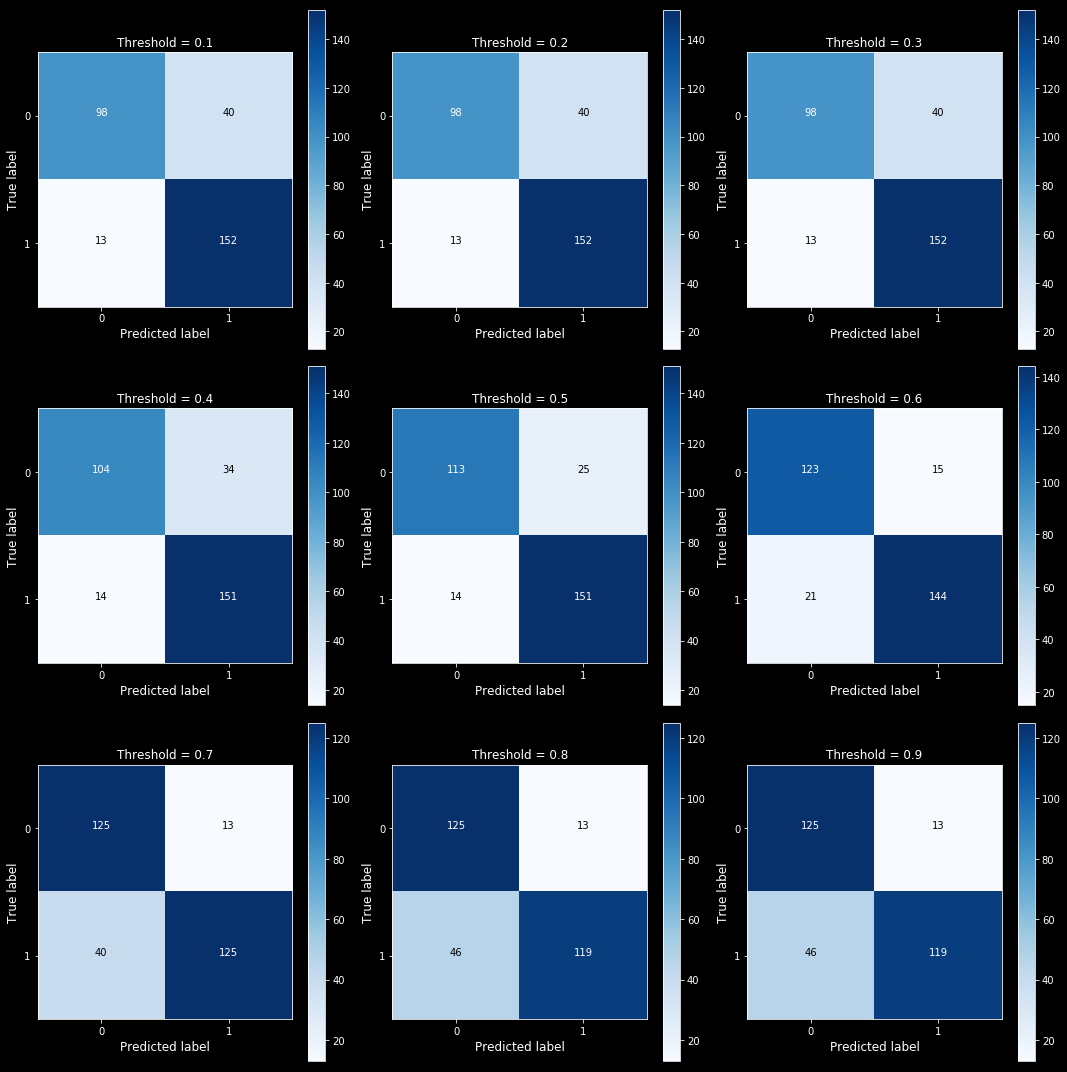

In [28]:
# Threshold
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize = (15,15))
j = 1
for i in thresholds :
    oof[val_idx] = model.predict_proba(train_df.iloc[val_idx][features])[:,1]>i
    plt.subplot(3,3,j)
    j += 1
    cm = confusion_matrix(target, oof.round())
    tp = cm[1,1]
    fn = cm[1,0]
    fp = cm[0,1]
    tn = cm[0,0]
    print('Recall w/ threshold = %s :'%i, (tp/(tp+fn)))
    class_names = [0,1]
    plot_confusion_matrix(cm, 
                          classes=class_names, 
                          title='Threshold = %s'%i) 